<a href="https://colab.research.google.com/github/Carlos99888/main_ml_final/blob/main/main_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Professor: Steve Geinitz

Student: Carlos Sanchez

Class: Machine Learning - CS-3120-001 - Fall 2025 - CRN: 53008

Reference:
 - ChatGPT: use this to make the base model, and explore different models. https://chatgpt.com/share/692cca42-7588-8010-bfe7-c25aaca4cdad
 - ClaudAI: use to assist in creating the NN. https://claude.ai/share/0ea97d56-74ac-4a24-a104-7b7b79a7245f

In [149]:
pip install backtesting

In [150]:
pip install polygon-api-client

In [151]:
from polygon import RESTClient

import pandas as pd
import pandas_ta as ta
import numpy as np
import time
from scipy.stats import norm
import csv
from datetime import datetime, date

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Defining a function to get the historical data for SPY, starting date to ending date

In [152]:
def get_spy_historical(start_date, end_date):


        rows = []

        for bar in client.list_aggs(
            ticker="SPY",
            multiplier=1,
            timespan="day",
            from_=start_date,
            to=end_date,
            adjusted=True,
            sort="asc",
            limit=50000
        ):
            # Convert timestamp
            ts = int(bar.timestamp)
            ts_sec = ts / 1000
            date = datetime.utcfromtimestamp(ts_sec).strftime("%Y-%m-%d")

            rows.append({
                "date": date,
                "open": bar.open,
                "high": bar.high,
                "low": bar.low,
                "close": bar.close,
                "volume": bar.volume
            })

        df = pd.DataFrame(rows)
        return df

Defining a function that applies technical indicators to the historical data of SPY.

Technical indicators are mathematical functions that uses price and volume to find trends in the market. Indicators used in this are:
- EMA (Exponential Moving Average): used for finding trends in the market that uses most recent prices.
- RSI (Relative Strenght Index): is momentum oscillator (oscillates 0-100) and its used for indicating when a stock is overbought or oversold. When is above 70 typically indicates is overbought and below 30 is oversold.
- Bollinger Bands: it measures market volatility. Helps identify high and low price level to spot a potential trend continuation or reversal.
- OBV (On-Balance Volume): relates an asset price and volume to measure buying and selling pressure. This can be used to confirm price trends or reversal (much like bollinger bands).
- CMF (Chaikin Money Flow): volume-weighted indicator to measure buying and selling pressure over specific period. It oscillates, positive values indicate buying pressure and negative is selling pressure.

In [153]:
def add_indicators(df):
        df.rename(columns={
            "date": "Date", "open": "Open", "high": "High",
            "low": "Low", "close": "Close", "volume": "Volume"
        }, inplace=True)
        df["Date"] = pd.to_datetime(df["Date"])
        df.set_index("Date", inplace=True)

        # Trend
        df["EMA_20"] = ta.ema(df["Close"], length=20)
        df["EMA_50"] = ta.ema(df["Close"], length=50)
        df["EMA_200"] = ta.ema(df["Close"], length=200)
        # Momentum
        df["RSI_14"] = ta.rsi(df["Close"], length=14)
        df = pd.concat([df, ta.macd(df["Close"])], axis=1)
        # Volatility
        df = pd.concat([df, ta.bbands(df["Close"])], axis=1)
        # Volume
        df["OBV"] = ta.obv(df["Close"], df["Volume"])
        df["CMF"] = ta.cmf(df["High"], df["Low"], df["Close"], df["Volume"])
        # Returns & Volatility
        df["return_1d"] = df["Close"].pct_change()
        df["return_5d"] = df["Close"].pct_change(5)
        df["volatility_20d"] = df["return_1d"].rolling(20).std()
        df = df.fillna(method="bfill").fillna(method="ffill")
        return df

Getting the historical data for SPY from starting date to end date. Apply the indicators to the dataset and saving it as a csv file. We will use this as our training data (if you are using Google Colab, this should be saved in your content folder).

In [154]:
#Instantiating the RESTful client api and passing the API key
#(You can get your API key from polygonIO by creating an account)
api_k = "uMcnW2vhdDQy9S956cDTSUjjoUNe1FQg"
client = RESTClient(api_k)

spy_df = get_spy_historical("2025-01-01", "2025-11-24")
spy_df_indicator = add_indicators(spy_df)
spy_df_indicator.to_csv("spy_hist_indicator.csv")

/tmp/ipython-input-2394281317.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.utcfromtimestamp(ts_sec).strftime("%Y-%m-%d")
/tmp/ipython-input-3233232610.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


## **Exploratory Data Analysis (EDA)**

Below are performing a basic EDA. First thing we want to do is find if there is any NaN values in our data set. We can see below we have none. The next thing we want to do is find any correlation in the features. We do this by using a correlation matrix heatmap. Red is strong correlation, blue is strong negative correlation, and white is weak or no correlation. By looking at the graph the ones that stand out that have weak to no correlation are 'Volume', 'BBB_5_2.0_2.0', 'volatility_20d', and 'return_1d'. I will remove this later on. However, I will leave the ligther colors since low correlation may provide independent information, this way it balance out some of redundancy of the other features.

Shape: (225, 23)

Missing values:
Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
EMA_20            0
EMA_50            0
EMA_200           0
RSI_14            0
MACD_12_26_9      0
MACDh_12_26_9     0
MACDs_12_26_9     0
BBL_5_2.0_2.0     0
BBM_5_2.0_2.0     0
BBU_5_2.0_2.0     0
BBB_5_2.0_2.0     0
BBP_5_2.0_2.0     0
OBV               0
CMF               0
return_1d         0
return_5d         0
volatility_20d    0
dtype: int64

Unique values per column:
Date              225
Open              222
High              221
Low               223
Close             225
Volume            225
EMA_20            206
EMA_50            176
EMA_200            26
RSI_14            223
MACD_12_26_9      200
MACDh_12_26_9     192
MACDs_12_26_9     192
BBL_5_2.0_2.0     221
BBM_5_2.0_2.0     220
BBU_5_2.0_2.0     221
BBB_5_2.0_2.0     221
BBP_5_2.0_2.0     221
OBV               224
CMF               206
return_1d         224
retu

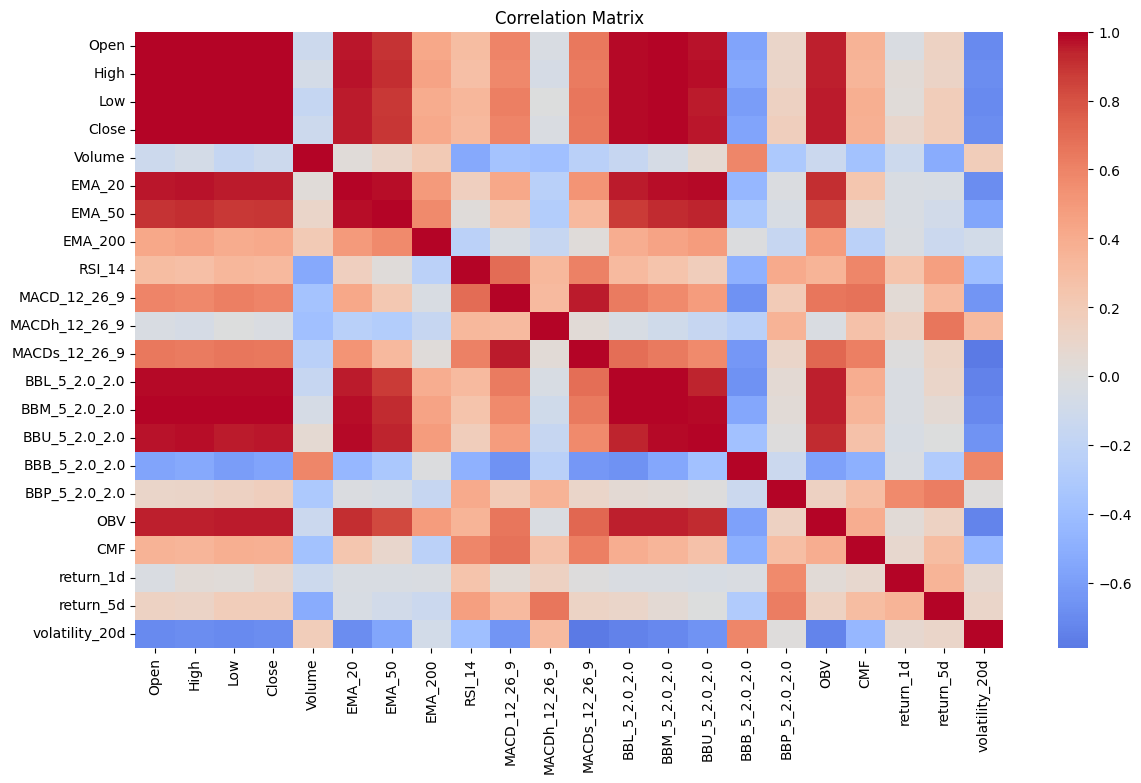

In [155]:
df = pd.read_csv("spy_hist_indicator.csv")

# -----------------------------
# Basic Cleanups
# -----------------------------
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isna().sum())

print("\nUnique values per column:")
print(df.nunique())

# -----------------------------
# Correlation Matrix
# -----------------------------
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(14,8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()



## **Linear Regression Model**
The first model we are testing is the Regression Model. Below we are loading the csv file and creating a new column "predict_next_close" which is going to be the next day closing price.

In [156]:
df = pd.read_csv("spy_hist_indicator.csv")
col_name = df.columns
col_name = col_name.drop(["Date",'Volume', 'BBB_5_2.0_2.0', 'volatility_20d', 'return_1d']) #droping the date, high,volume and low as they are not need when using the indicators
df["predict_next_close"] = df["Close"].shift(-1)


# keep df intact
df_train = df.dropna().copy()

X = df_train[col_name]
y = df_train["predict_next_close"]

#train split, using 80% (170 rows) for training and 20% (43 rows) for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

#train model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

Below are the graph for RSME and MAE (created by the code below). The train RSME got a score of 6.76 and the MAE 4.65. This means on average the model was off by 6.76 and 4.65, in closing price. Additionally the model predicted the next day close price to be 663.80 and the actual value 675.02 for 2025-11-25. Even though the prediction is off from what the RSME and MAE suggested, that just shows that linear regression has it limits when trying to predict something so complex like the stock market.


Predicted Next-Day SPY Close (2025-11-25): 663.80

Previous Day SPY Close (2025-11-24): 668.73


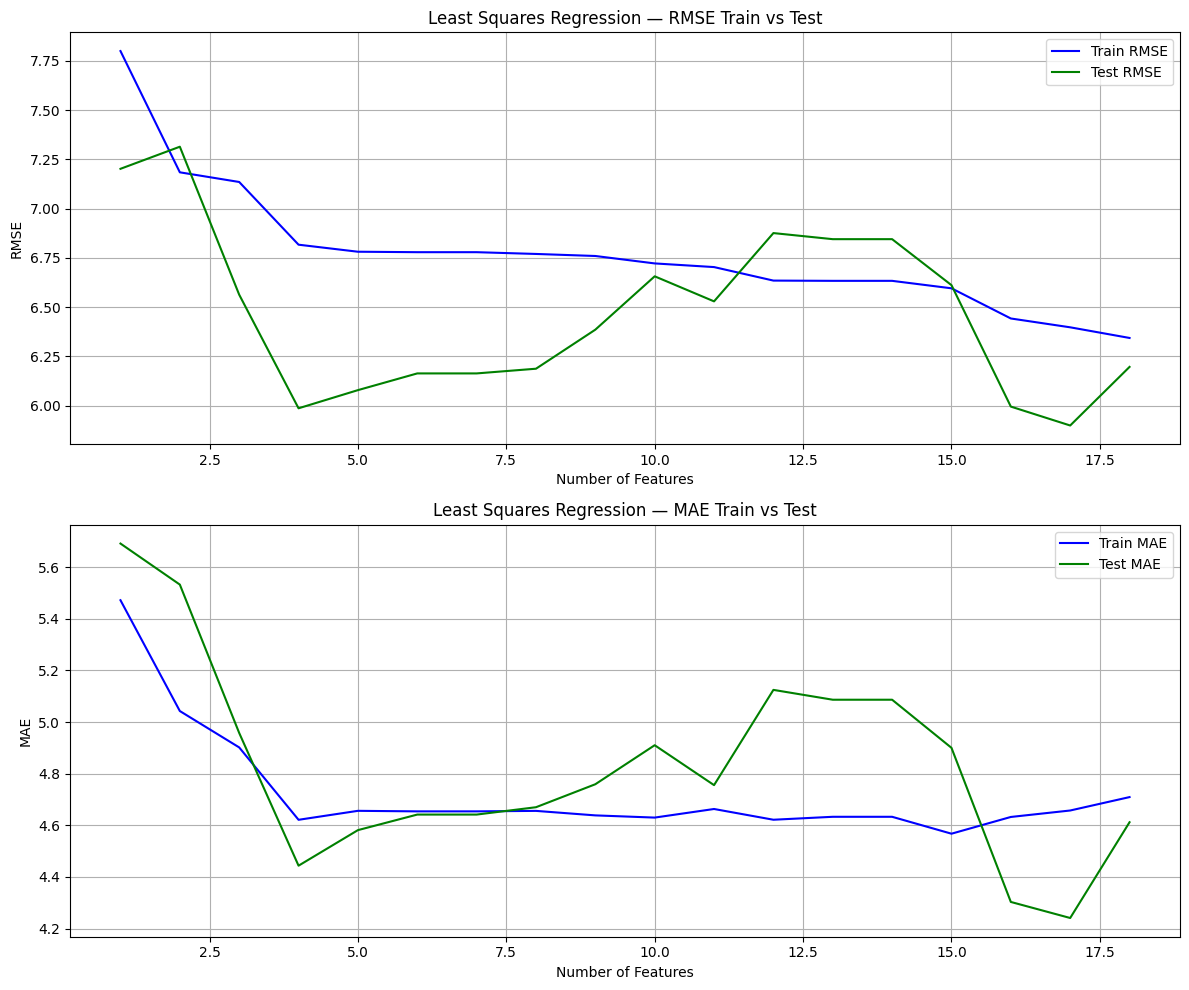

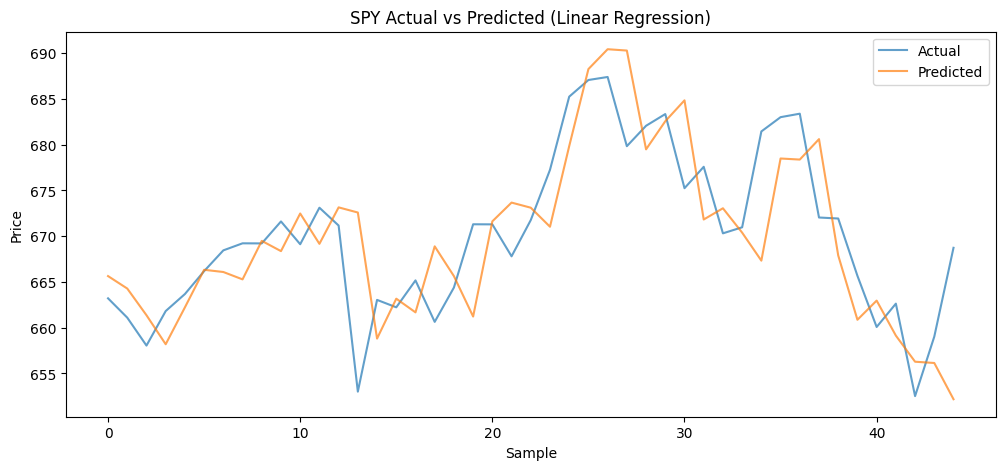

In [157]:
preds = regression_model.predict(X_test)
# Lists to store metrics
rmse_train_list = []
rmse_test_list = []
mae_train_list = []
mae_test_list = []

# Range of features
min_features = 1
num_features = len(col_name)

# Sweep feature count
for k in range(min_features, num_features + 1):

    # First k features only
    X_train_k = X_train.iloc[:, :k]
    X_test_k = X_test.iloc[:, :k]

    model = LinearRegression()
    model.fit(X_train_k, y_train)

    # Predictions
    pred_train = model.predict(X_train_k)
    pred_test = model.predict(X_test_k)

    # RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

    # MAE
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)

    # Store
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    mae_train_list.append(mae_train)
    mae_test_list.append(mae_test)

# Predict next-day price
next_day = pd.to_datetime(df.iloc[-1]['Date']) + pd.Timedelta(days=1)
next_day_str = next_day.strftime("%Y-%m-%d")
latest_row = df[col_name].iloc[-1:]
next_close_prediction = regression_model.predict(latest_row)[0]
print(f"\nPredicted Next-Day SPY Close ({next_day_str}): {next_close_prediction:.2f}")
print(f"\nPrevious Day SPY Close ({df.iloc[-1]['Date']}): {df.iloc[-1]['Close']}")


# -------------------------------------------------------------
# Plotting (RMSE top subplot, MAE bottom subplot)
# -------------------------------------------------------------
plt.figure(figsize=(12, 10))

# RMSE graph
plt.subplot(2, 1, 1)
plt.plot(range(min_features, num_features + 1), rmse_train_list, label='Train RMSE', color='blue')
plt.plot(range(min_features, num_features + 1), rmse_test_list, label='Test RMSE', color='green')
plt.title("Least Squares Regression — RMSE Train vs Test")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()

# MAE graph
plt.subplot(2, 1, 2)
plt.plot(range(min_features, num_features + 1), mae_train_list, label='Train MAE', color='blue')
plt.plot(range(min_features, num_features + 1), mae_test_list, label='Test MAE', color='green')
plt.title("Least Squares Regression — MAE Train vs Test")
plt.xlabel("Number of Features")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the actual value vs the predicted value
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(preds, label='Predicted', alpha=0.7)
plt.title("SPY Actual vs Predicted (Linear Regression)")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.legend()
plt.show()

## **Gradient Boosting Model**
The next model we are using is the Gradient Boosting Regressor.
As show below the RSME is 15.33 which is way higher then the regression model. Also the predicted close price was 658.54 and the actual closing price was 675.02 (for the SPY 2025-11-25). So it seems the GBR did much worst than the linear regression model. This is due to that GBR trys to learn nonlinear patterns but the stock-market tends to be more linear. Hence the GBR did much worst. Which came as a suprise for me. I thought GBR would do much better but i guess it does make sense; if you look at the over arching shape of the market it moves linearly up or it linearly down.

In [158]:
# Lists to store RMSE values
rmse_train_list = []
rmse_test_list = []

# List of n_estimators to try
poss_num_estimators = list(range(1, 402, 10))

best_rmse = float('inf')
best_model = None
best_n = None

for n in poss_num_estimators:

    model = GradientBoostingRegressor(
        n_estimators=n,
        learning_rate=0.1,
        random_state=2
    )

    model.fit(X_train, y_train)

    train_rmse = np.sqrt(np.mean((y_train - model.predict(X_train))**2))
    test_rmse = np.sqrt(np.mean((y_test - model.predict(X_test))**2))

    rmse_train_list.append(train_rmse)
    rmse_test_list.append(test_rmse)

    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_model = model
        best_n = n

print("\nBest Gradient Boosting Model:")
print("  n_estimators =", best_n)
print("  Test RMSE    =", best_rmse)

# --- Predict NEXT DAY closing price ---
X_last = df[col_name].iloc[-1:].copy()

next_close = best_model.predict(X_last)[0]
print(f"\nPredicted Next-Day SPY Close ({next_day_str}): {next_close:.2f}")
print(f"\nPrevious Day SPY Close ({df.iloc[-1]['Date']}): {df.iloc[-1]['Close']}")


Best Gradient Boosting Model:
  n_estimators = 271
  Test RMSE    = 13.145935808474311

Predicted Next-Day SPY Close (2025-11-25): 658.54

Previous Day SPY Close (2025-11-24): 668.73


Before moving forward I tried tunning the model by using grid search.
But it performed just the same as before.

In [159]:
# prepare the time-series split

tscv = TimeSeriesSplit(n_splits=5)

# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_leaf': [1, 3, 5]
}

# create the model
gb = GradientBoostingRegressor(random_state=42)

# grid Search with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train.values.ravel())

# best model
best_gb = grid_search.best_estimator_
print("\nBest Parameters Found:")
print(grid_search.best_params_)

# evaluate on test set

preds = best_gb.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("\nGradient Boosting (Tuned) Performance:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

# predict tomorrow's closing price
next_close_pred = best_gb.predict(X.iloc[-1:].copy())[0]
print(f"\nPredicted Next-Day SPY Close ({next_day_str}): {next_close:.2f}")
print(f"\nPrevious Day SPY Close {df.iloc[-1]['Date']}: {df.iloc[-1]['Close']}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters Found:
{'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 300, 'subsample': 1.0}

Gradient Boosting (Tuned) Performance:
MAE  = 13.9251
RMSE = 16.3853

Predicted Next-Day SPY Close (2025-11-25): 658.54

Previous Day SPY Close 2025-11-24: 668.73


## **Neural Network with 3 layers**
The last approach is using a NN. The NN are good at learning patterns, so I'm optimistic that the model will pick up trends and use that to have a better prediction than the rest of the other models.

The prepare_features_simple() function is preparing the features needed for testing the NN. The plot_results() function is to plot the result.

In [160]:
def prepare_features_simple(df):
    """
    Use existing features directly - minimal feature engineering
    """
    df = df.copy()

    # Drop columns you don't want
    df = df.drop(["Date", 'Volume', 'BBB_5_2.0_2.0', 'volatility_20d', 'return_1d'], axis=1)

    # Target: next day's return
    df['next_day_return'] = df['Close'].pct_change().shift(-1)

    # Features: ONLY include columns that still exist after dropping
    feature_cols = ['Close', 'EMA_20', 'EMA_50', 'RSI_14',
                    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
                    'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0',
                    'BBP_5_2.0_2.0', 'OBV', 'CMF',
                    'return_5d']  # Removed: BBB_5_2.0_2.0, volatility_20d, return_1d

    X = df[feature_cols]
    y = df['next_day_return']

    # Drop rows with NaN
    valid_idx = ~(X.isna().any(axis=1) | y.isna())
    X = X[valid_idx]
    y = y[valid_idx]

    return X, y

def plot_results(history, actual_returns, pred_returns, actual_prices, pred_prices, current_prices):
    """
    Visualize results
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Training history
    axes[0, 0].plot(history.history['loss'], label='Train Loss', alpha=0.8)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', alpha=0.8)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Neural Network Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Return predictions
    axes[0, 1].scatter(actual_returns*100, pred_returns*100, alpha=0.5, s=30)
    axes[0, 1].plot([actual_returns.min()*100, actual_returns.max()*100],
                     [actual_returns.min()*100, actual_returns.max()*100],
                     'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Return (%)')
    axes[0, 1].set_ylabel('Predicted Return (%)')
    axes[0, 1].set_title('Return Predictions')
    axes[0, 1].grid(True, alpha=0.3)

    # Price predictions
    axes[1, 0].scatter(actual_prices, pred_prices, alpha=0.5, s=30)
    axes[1, 0].plot([actual_prices.min(), actual_prices.max()],
                     [actual_prices.min(), actual_prices.max()],
                     'r--', lw=2)
    axes[1, 0].set_xlabel('Actual Price ($)')
    axes[1, 0].set_ylabel('Predicted Price ($)')
    axes[1, 0].set_title('Price Predictions')
    axes[1, 0].grid(True, alpha=0.3)

    # Time series
    axes[1, 1].plot(actual_prices, label='Actual', alpha=0.7, linewidth=2)
    axes[1, 1].plot(pred_prices, label='Predicted', alpha=0.7, linewidth=2)
    axes[1, 1].set_xlabel('Test Sample')
    axes[1, 1].set_ylabel('Price ($)')
    axes[1, 1].set_title('Actual vs Predicted Prices Over Time')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


- The **build_model()** function is using the Keras sequntial NN, it has 3 layers (not counting the input and dropout layer).

- **train_model()** function trains both models and evaluates performance. It splits the data 80% for training and 20% for testing.
  - It also standardizes the features and trains the NN with early stopping if the loss doesn't improve.
  - trains gradient boosting model and uses the NN to average them, for an ensemble approach.

- **predict_next_day()** function, performance a prediction for tomorrow's closing price using the trained models.
  - recreates all features and scales the features.
  - gets prediction from NN and gradient boosting, and averages the two.
  -it returns predicted value and predicted return percentage

In [161]:
def build_model(input_dim):
    """
    Build a simple model for return prediction
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)), #input layer (number of features)
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)), #Layer 1, 32 neurons with ReLu and L2 Regularization
        layers.Dropout(0.4), #drops 40% to prevent overfitting
        layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)), #layer 2, 16 neurons with ReLu and L2 Regularization
        layers.Dropout(0.3), #drop 30%
        layers.Dense(1)  # Layer 3, predict next day return (percentage)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

def train_model(df, test_size=0.2, epochs=150):
    """
    Train model to predict next-day returns
    """
    # Prepare features
    X, y = prepare_features_simple(df)
    current_close = df.loc[y.index, 'Close']


    print(f"Total samples: {len(X)}")
    print(f"Features: {list(X.columns)}")
    print(f"\nTarget (next day return) stats:")
    print(f"  Mean: {y.mean()*100:.3f}%")
    print(f"  Std: {y.std()*100:.3f}%")
    print(f"  Min: {y.min()*100:.2f}%, Max: {y.max()*100:.2f}%")

    # Split (time series - no shuffle)
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    close_train, close_test = current_close[:split_idx], current_close[split_idx:]

    print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build and train neural network
    print("\n" + "="*60)
    print("Training Neural Network...")
    print("="*60)

    nn_model = build_model(X_train_scaled.shape[1])

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=0
    )

    history = nn_model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Also train a Gradient Boosting model (ensemble approach)
    print("\nTraining Gradient Boosting Model...")
    gb_model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    gb_model.fit(X_train, y_train)

    # Predictions
    nn_pred_return = nn_model.predict(X_test_scaled, verbose=0).flatten()
    gb_pred_return = gb_model.predict(X_test)

    # Ensemble: average both predictions
    pred_return = (nn_pred_return + gb_pred_return) / 2

    # Convert returns to prices
    pred_prices = close_test * (1 + pred_return)
    actual_prices = close_test * (1 + y_test.values)

    # Evaluate
    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)

    # Return prediction metrics
    mae_return = np.mean(np.abs(y_test.values - pred_return)) * 100
    print(f"MAE on return prediction: {mae_return:.3f}%")

    # Price prediction metrics
    mae_price = np.mean(np.abs(actual_prices - pred_prices))
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100
    print(f"MAE on price prediction: ${mae_price:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Directional accuracy
    actual_direction = y_test.values > 0
    pred_direction = pred_return > 0
    directional_acc = np.mean(actual_direction == pred_direction) * 100
    print(f"Directional Accuracy: {directional_acc:.2f}%")

    # Show predictions
    print("\nSample Predictions (last 10 test days):")
    print("-" * 100)
    print(f"{'Current':<12} {'Act Return':<12} {'Pred Return':<12} {'Actual Next':<12} {'Pred Next':<12} {'Error':<12}")
    print("-" * 100)
    for i in range(max(0, len(y_test)-10), len(y_test)):
      error = pred_prices.iloc[i] - actual_prices.iloc[i]
      print(f"${close_test.iloc[i]:<11.2f} "
          f"{y_test.iloc[i]*100:+11.2f}% "
          f"{pred_return[i]*100:+11.2f}% "
          f"${actual_prices.iloc[i]:<11.2f} "
          f"${pred_prices.iloc[i]:<11.2f} "
          f"${error:+11.2f}")

    print("="*60)

    # Plot
    plot_results(history, y_test.values, pred_return, actual_prices, pred_prices, close_test)

    return nn_model, gb_model, scaler, X.columns.tolist()


def predict_next_day(nn_model, gb_model, scaler, feature_cols, current_data):
    """
    Predict tomorrow's close using ensemble of models
    """
    df = current_data.copy()

    # Recreate all features
    X, y = prepare_features_simple(df)
    current_close = df.loc[y.index, 'Close']


    if len(X) == 0:
        print("Error: Not enough data to create features")
        return None, None

    # Get last row (most recent day)
    X_last = X.iloc[[-1]][feature_cols]
    close_today = df['Close'].iloc[-1]


    # Scale features
    X_scaled = scaler.transform(X_last)

    # Predict return using both models
    nn_return = nn_model.predict(X_scaled, verbose=0)[0][0]
    gb_return = gb_model.predict(X_last)[0]

    # Ensemble prediction
    pred_return = (nn_return + gb_return) / 2

    # Convert to price
    pred_price = close_today * (1 + pred_return)

    return pred_price, pred_return

Below we are running the NN. Since NN don't give the same answer, I decided to use a for loop and run it 10 times and use their average for the final prediction closing price. The NN predicted was 674.70 and the actual closing price was 675.02 for 2025-11-25. Even though the prediction was close. After testing it multiple times it is usually off by $5-15, which is somewhat close to the linear regression.

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 0.915%
MAE on price prediction: $6.12
MAPE: 0.91%
Directional Accuracy: 44.44%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       -0.38% $683.00      $678.83      $      -4.17
$683.00            +0.06%       -0.34% $683.38      $680.71      $      -2.67
$683.38            

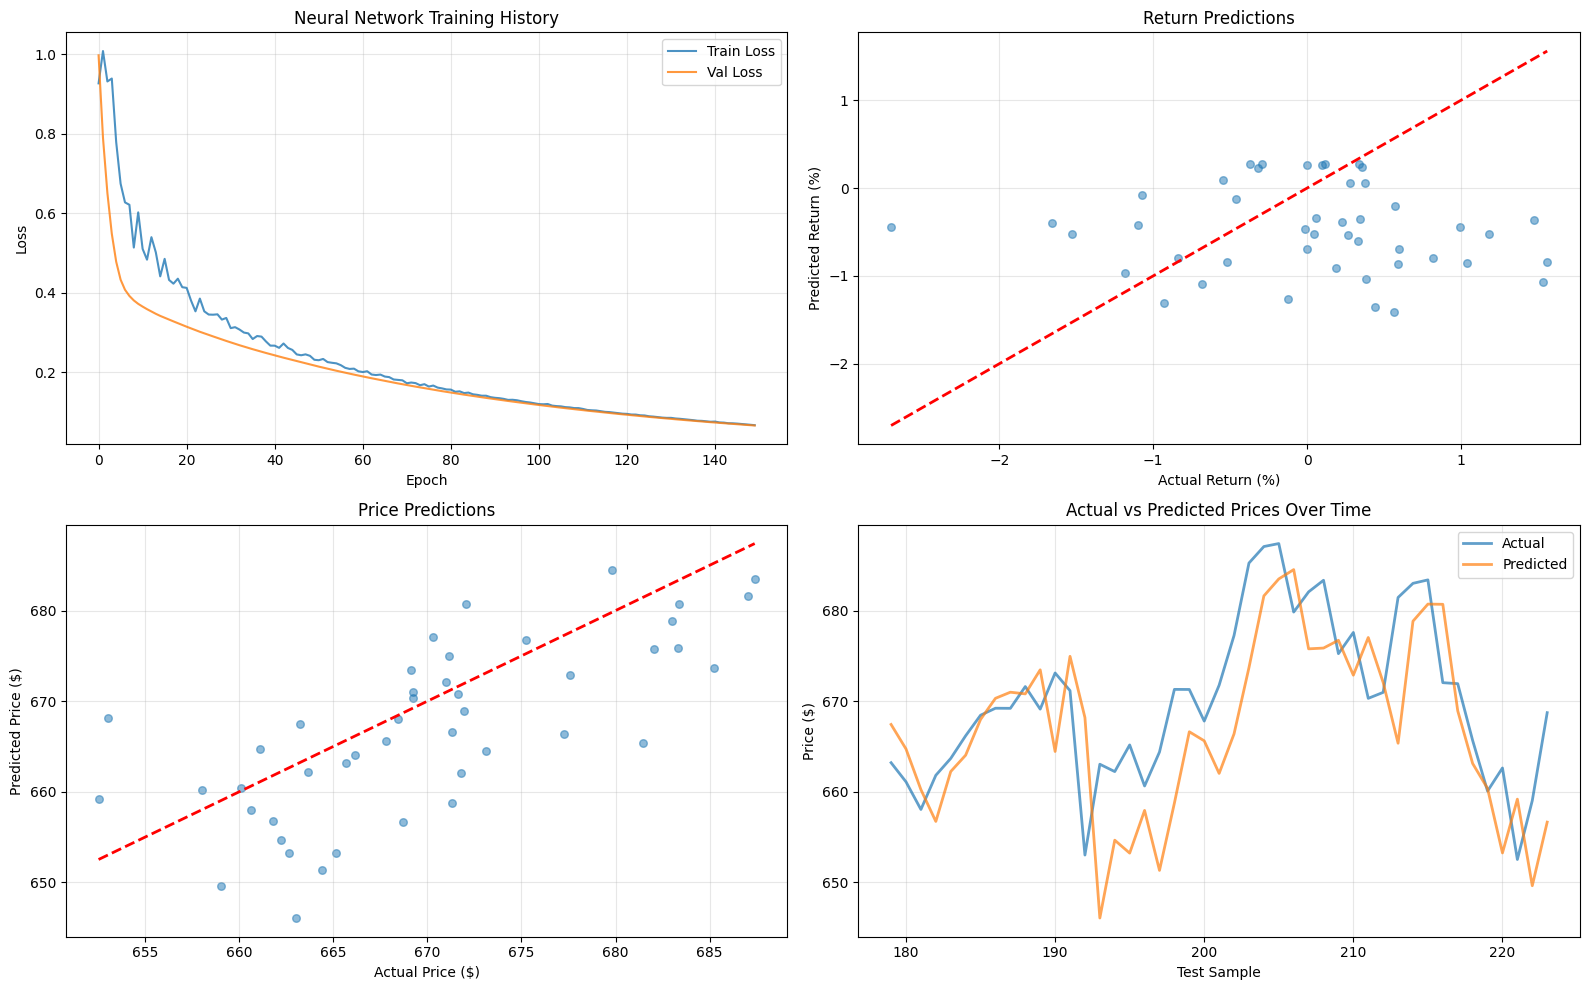

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 3.038%
MAE on price prediction: $20.33
MAPE: 3.04%
Directional Accuracy: 53.33%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       +3.41% $683.00      $704.66      $     +21.66
$683.00            +0.06%       +3.48% $683.38      $706.78      $     +23.40
$683.38           

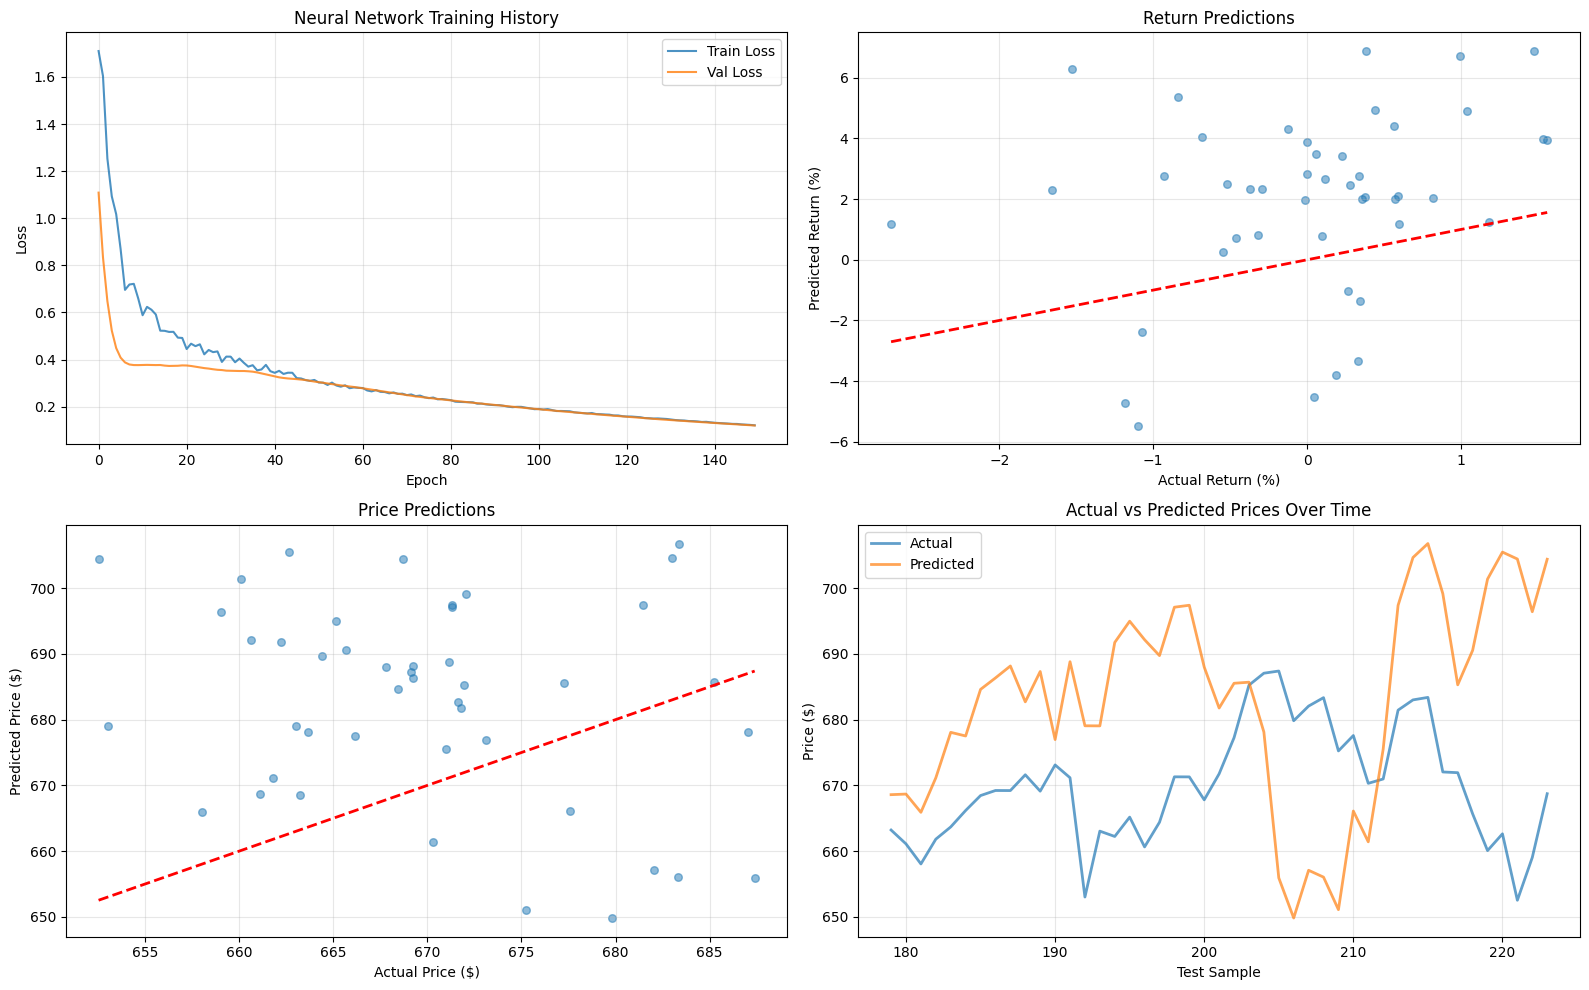

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 1.859%
MAE on price prediction: $12.47
MAPE: 1.87%
Directional Accuracy: 57.78%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       +0.70% $683.00      $686.22      $      +3.22
$683.00            +0.06%       +1.93% $683.38      $696.18      $     +12.80
$683.38           

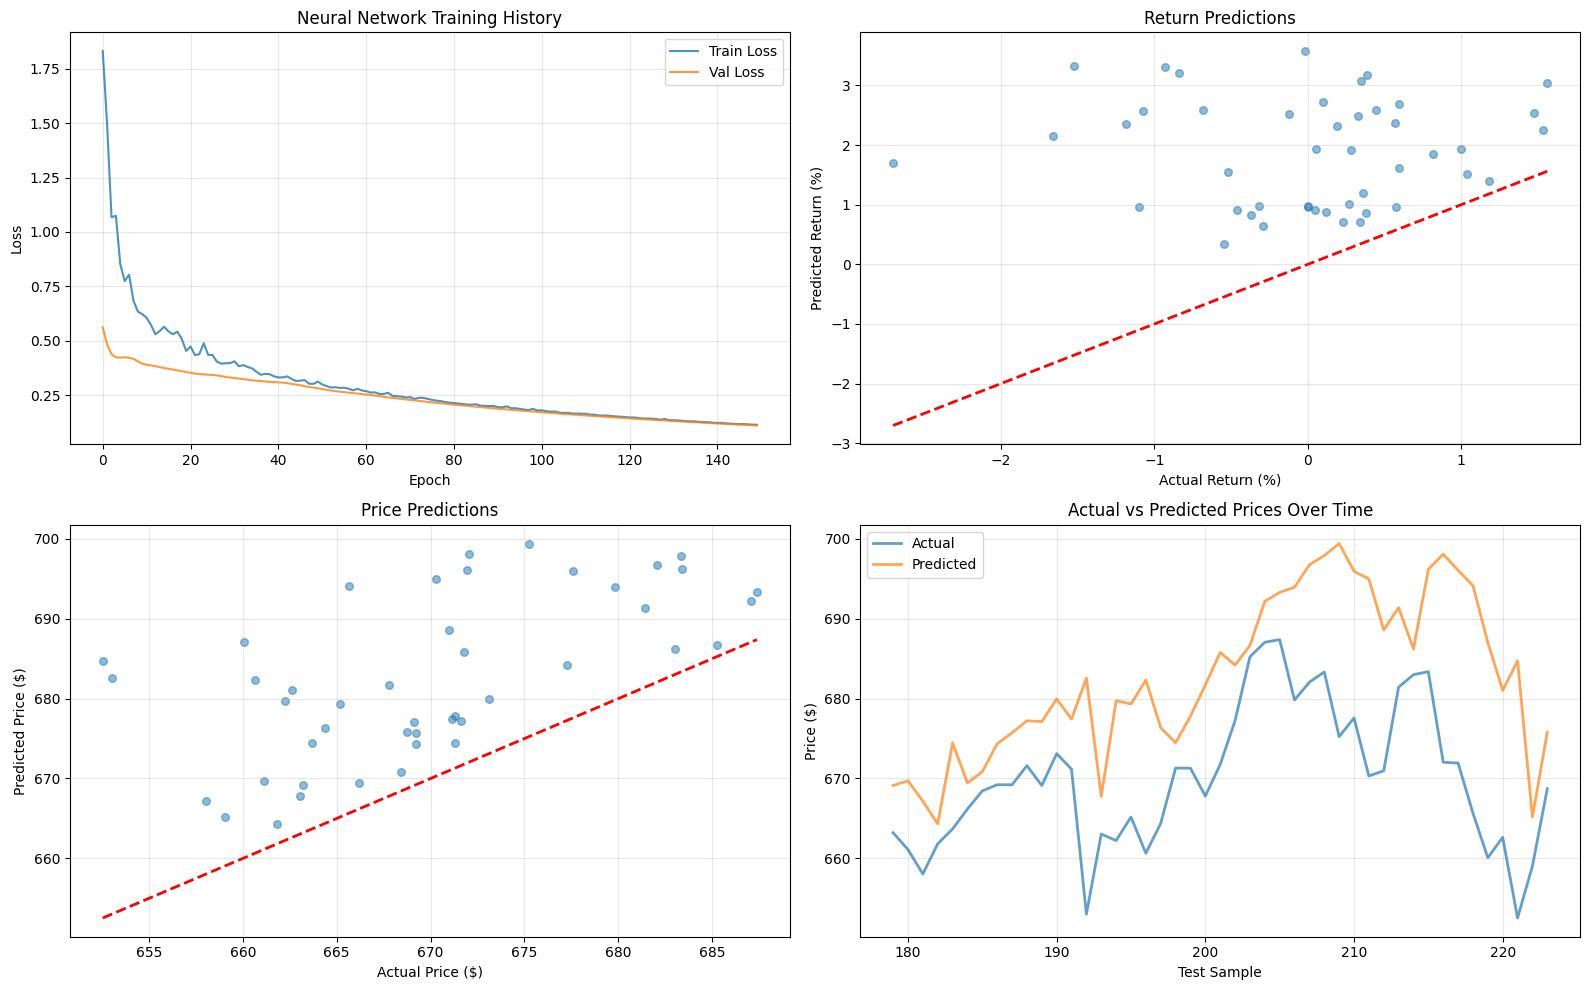

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 0.652%
MAE on price prediction: $4.36
MAPE: 0.65%
Directional Accuracy: 44.44%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       -0.04% $683.00      $681.20      $      -1.80
$683.00            +0.06%       +0.05% $683.38      $683.33      $      -0.05
$683.38            

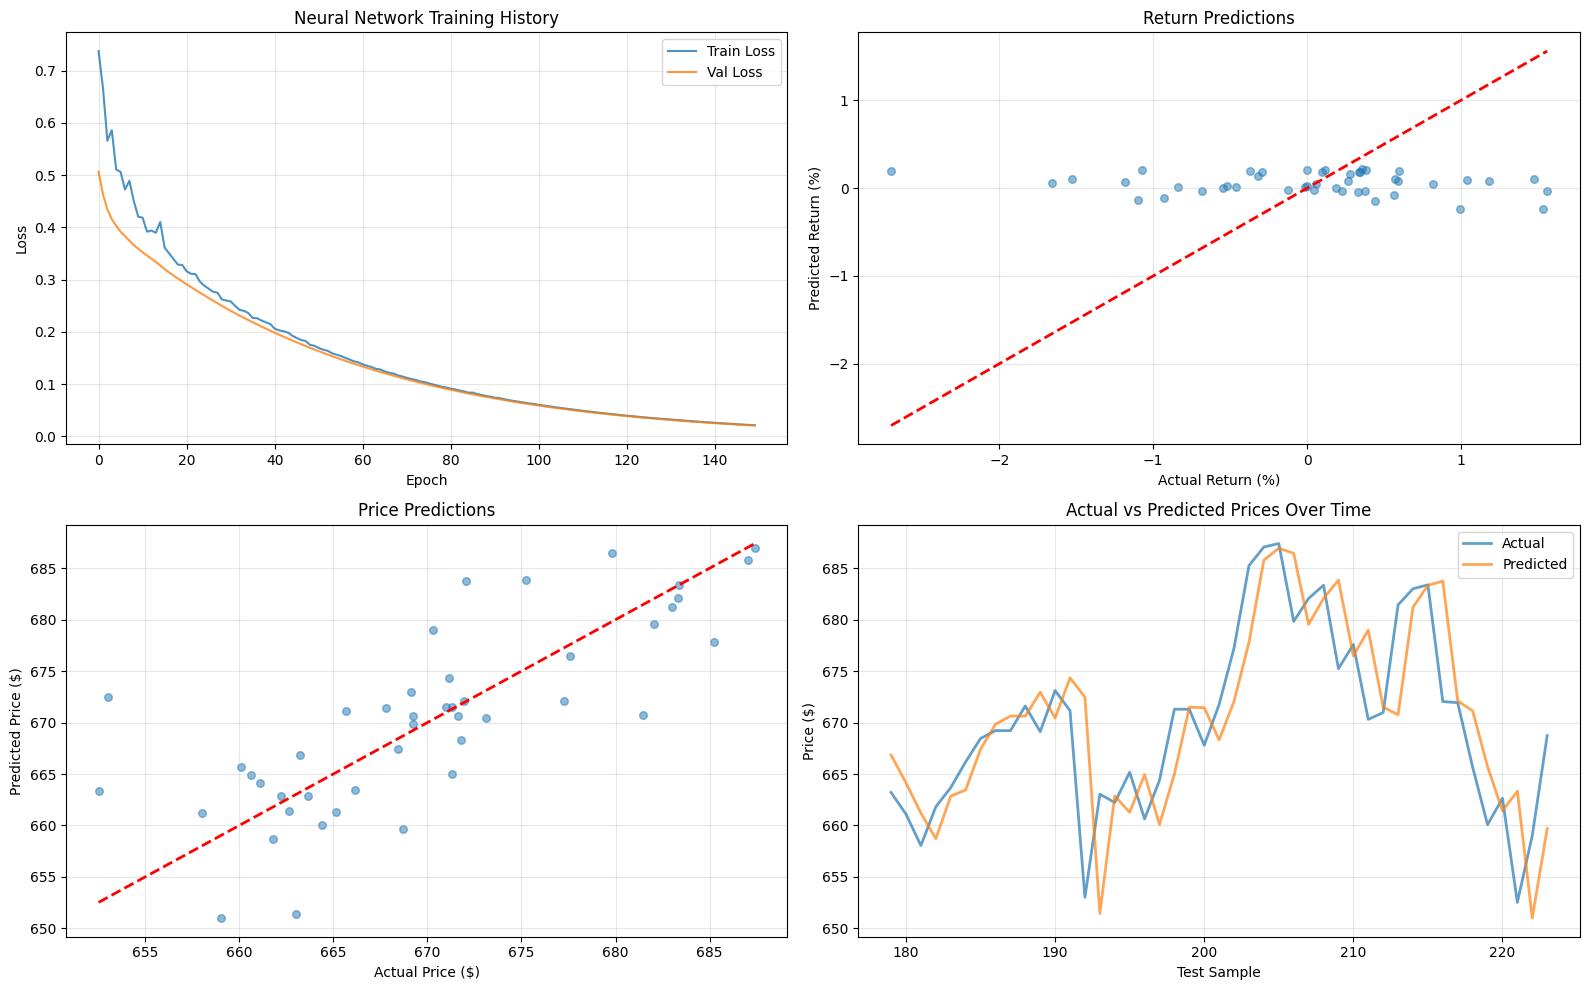

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 1.817%
MAE on price prediction: $12.19
MAPE: 1.82%
Directional Accuracy: 60.00%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       -1.15% $683.00      $673.59      $      -9.41
$683.00            +0.06%       +0.06% $683.38      $683.42      $      +0.04
$683.38           

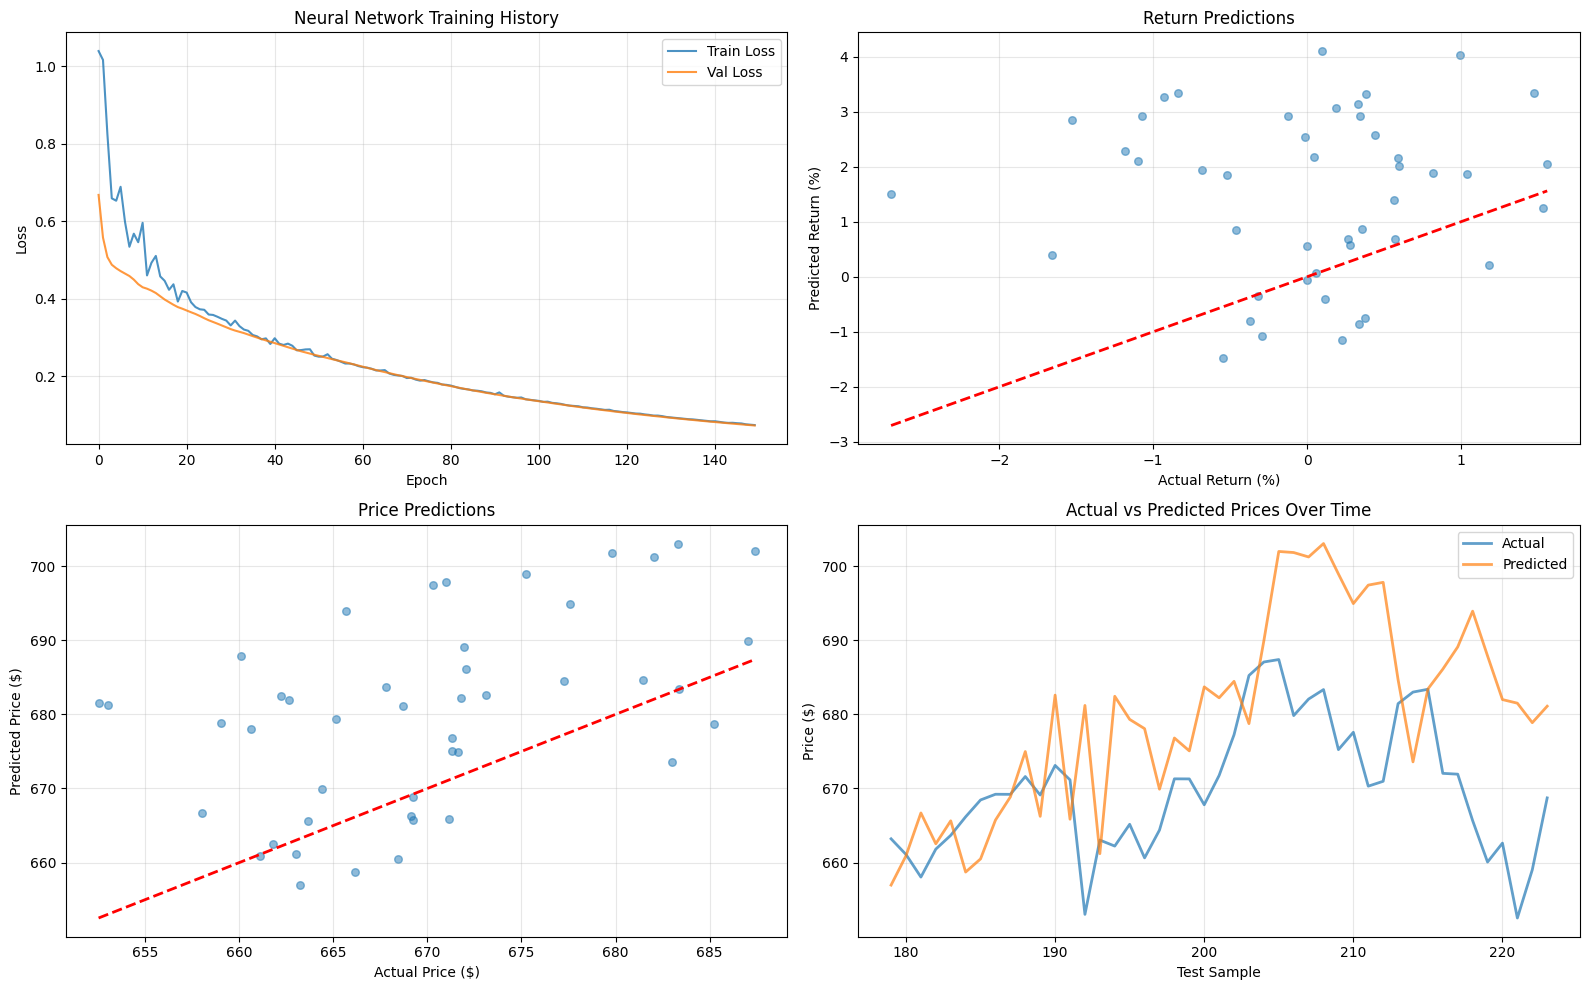

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 0.811%
MAE on price prediction: $5.45
MAPE: 0.82%
Directional Accuracy: 55.56%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       +0.84% $683.00      $687.16      $      +4.16
$683.00            +0.06%       +1.81% $683.38      $695.39      $     +12.01
$683.38            

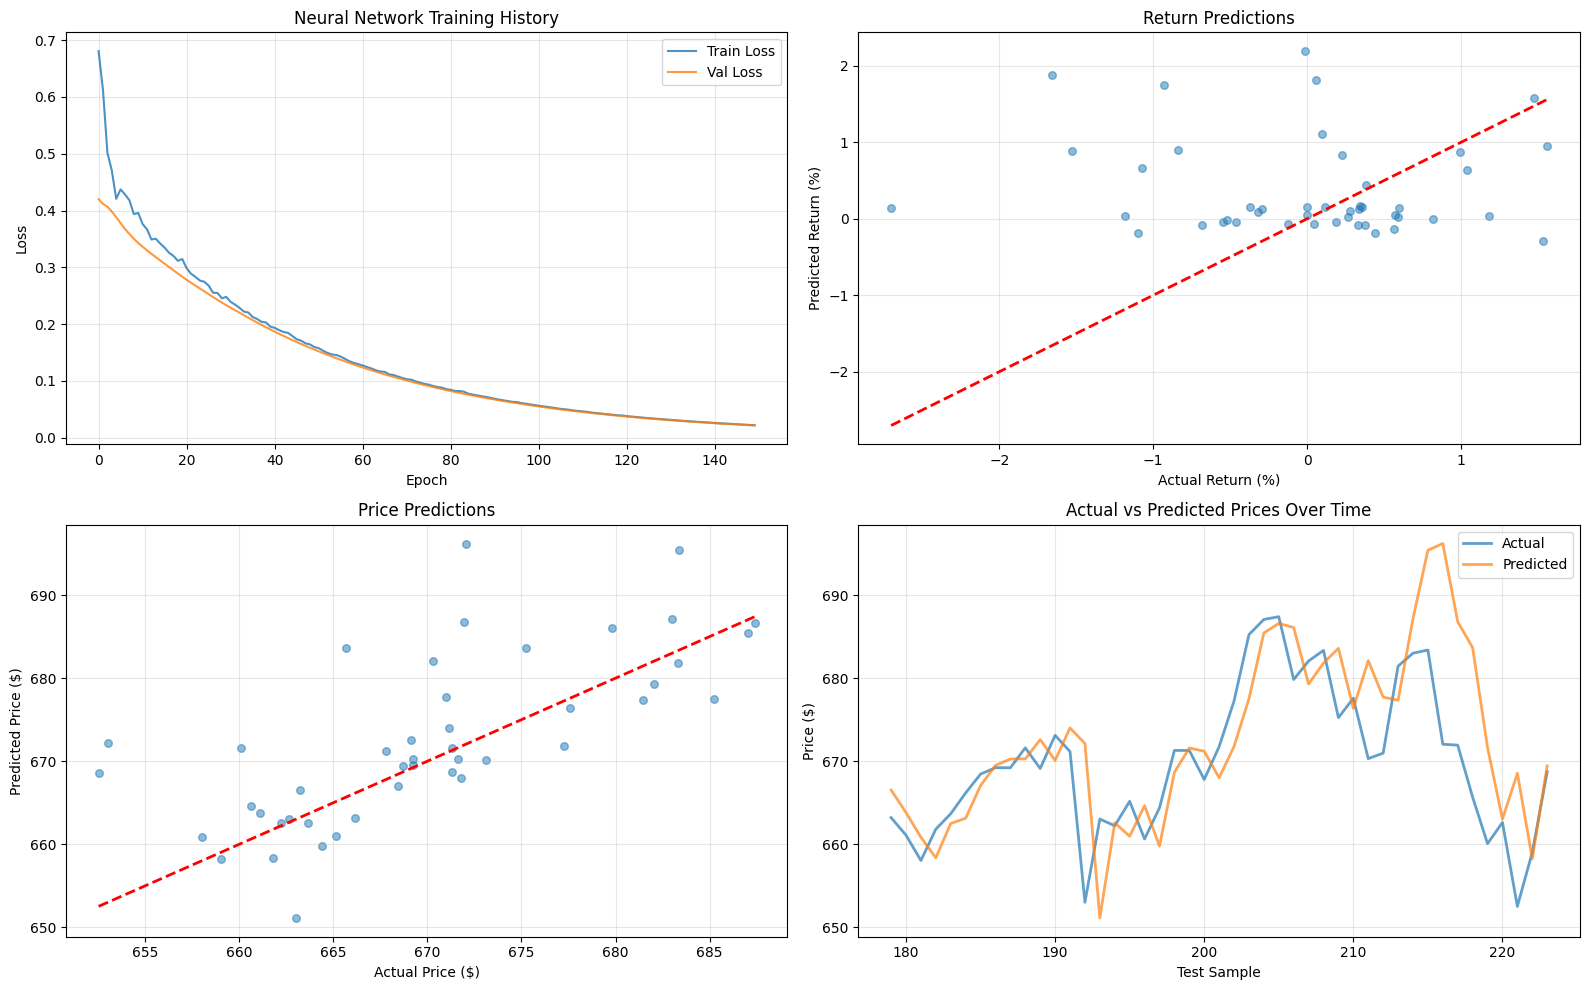

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 0.653%
MAE on price prediction: $4.37
MAPE: 0.66%
Directional Accuracy: 55.56%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       +0.09% $683.00      $682.02      $      -0.98
$683.00            +0.06%       +0.18% $683.38      $684.23      $      +0.85
$683.38            

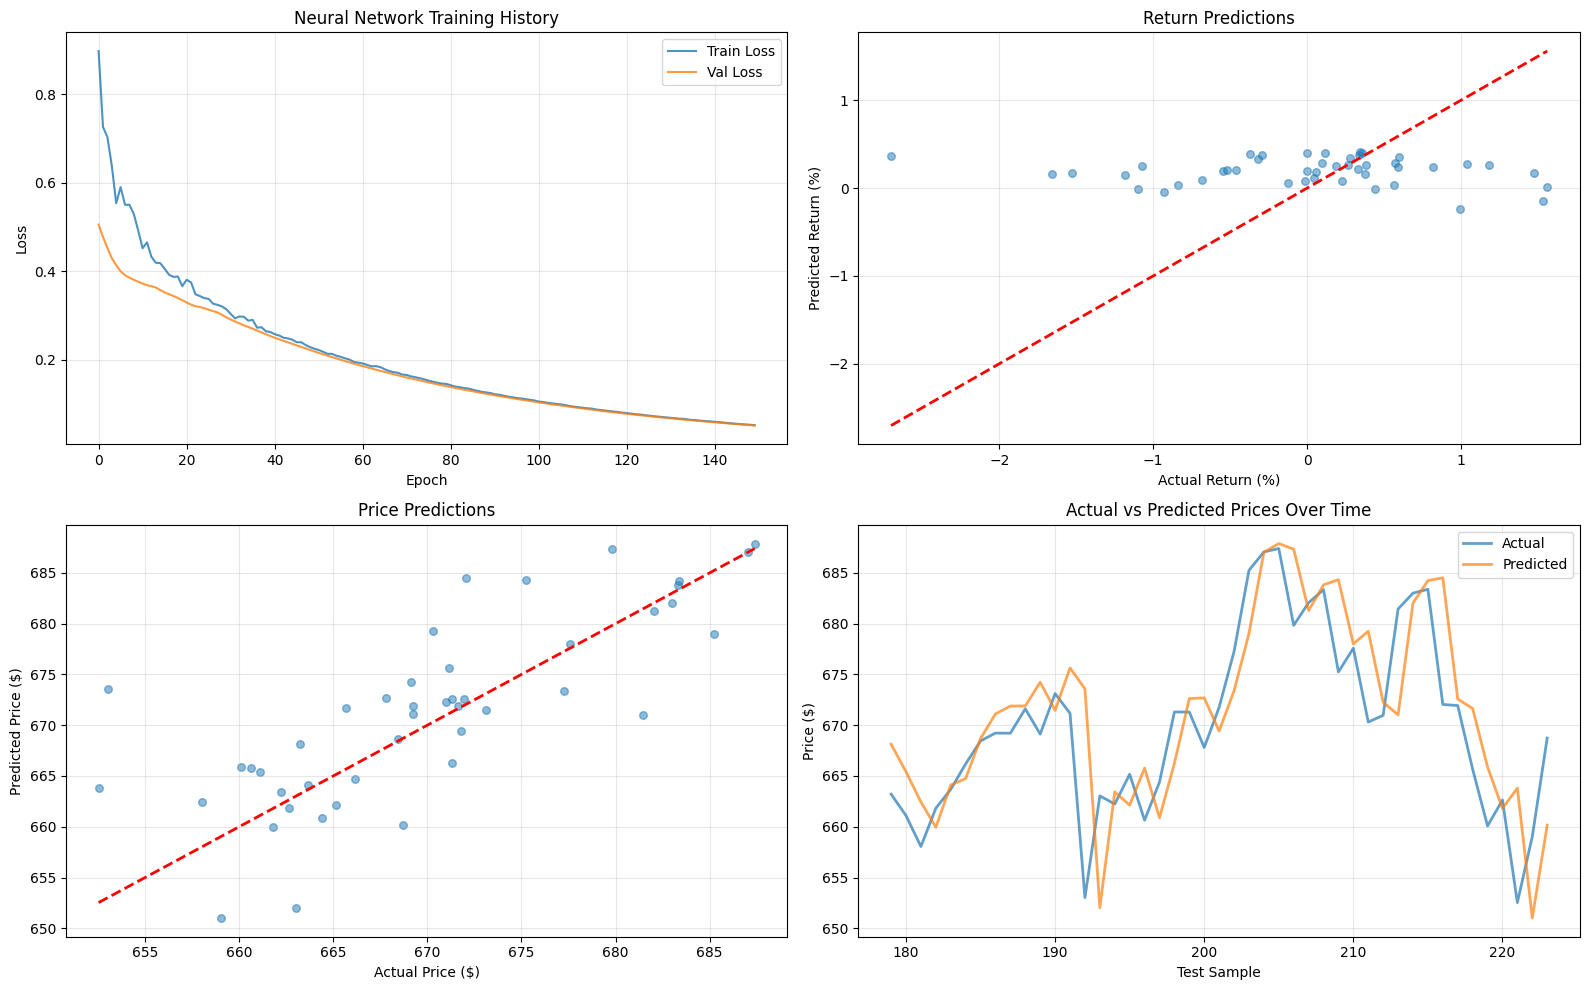

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 0.800%
MAE on price prediction: $5.37
MAPE: 0.80%
Directional Accuracy: 57.78%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       +0.90% $683.00      $687.57      $      +4.57
$683.00            +0.06%       +0.53% $683.38      $686.60      $      +3.22
$683.38            

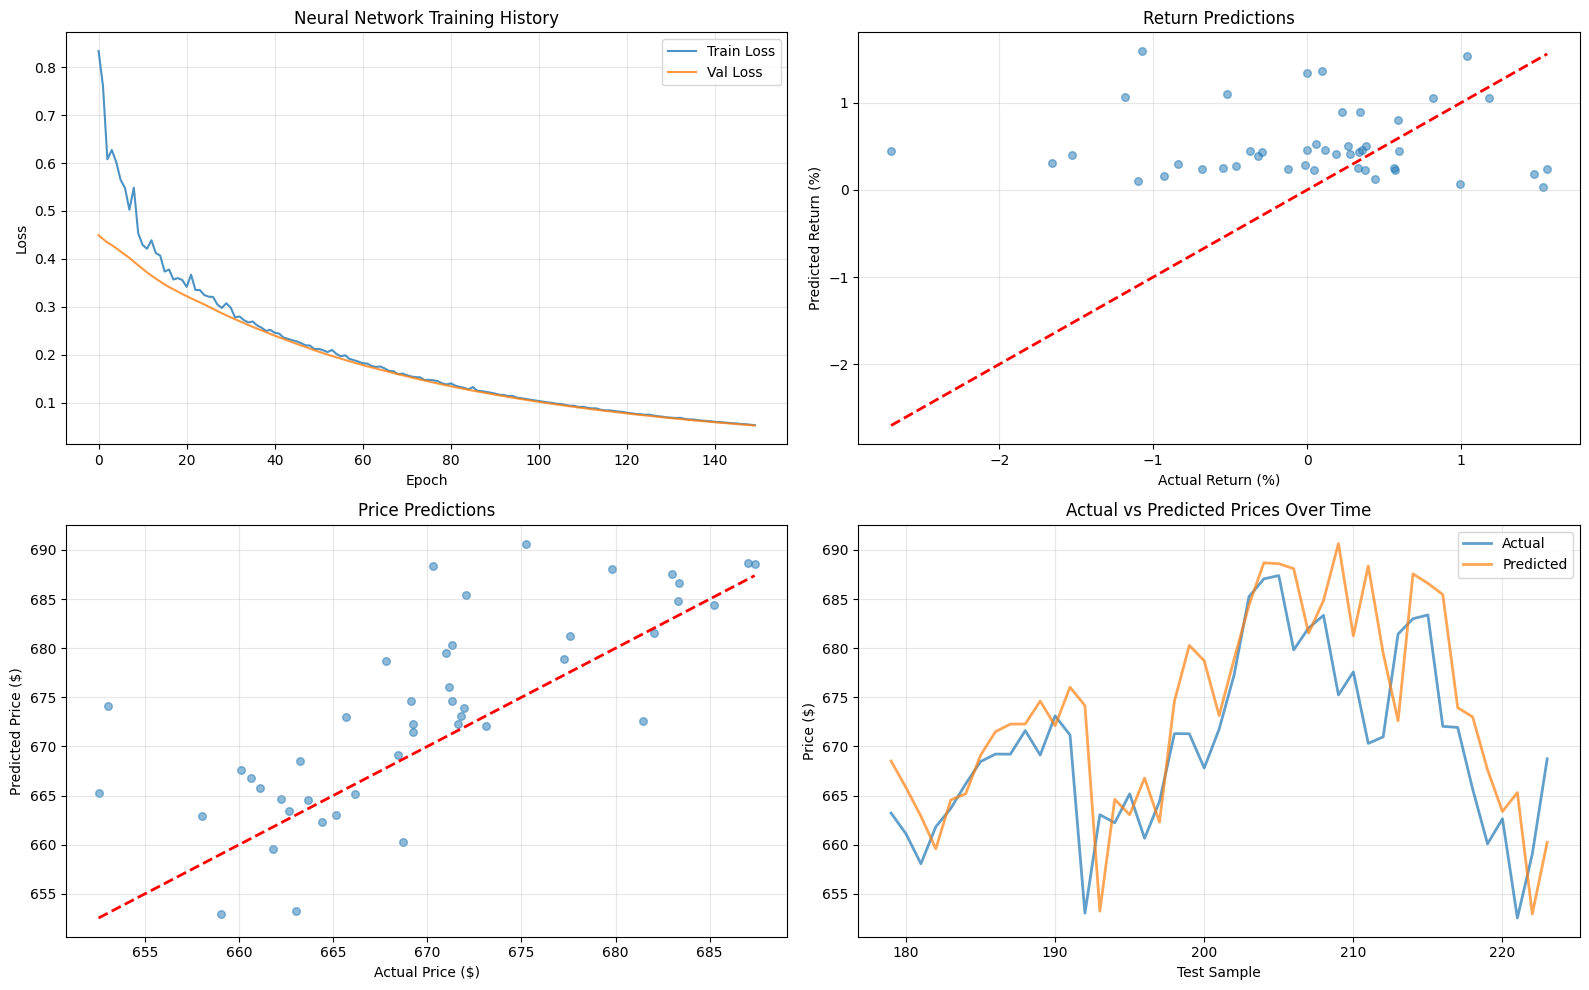

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 3.033%
MAE on price prediction: $20.34
MAPE: 3.03%
Directional Accuracy: 42.22%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       -2.85% $683.00      $662.03      $     -20.97
$683.00            +0.06%       -3.22% $683.38      $661.03      $     -22.35
$683.38           

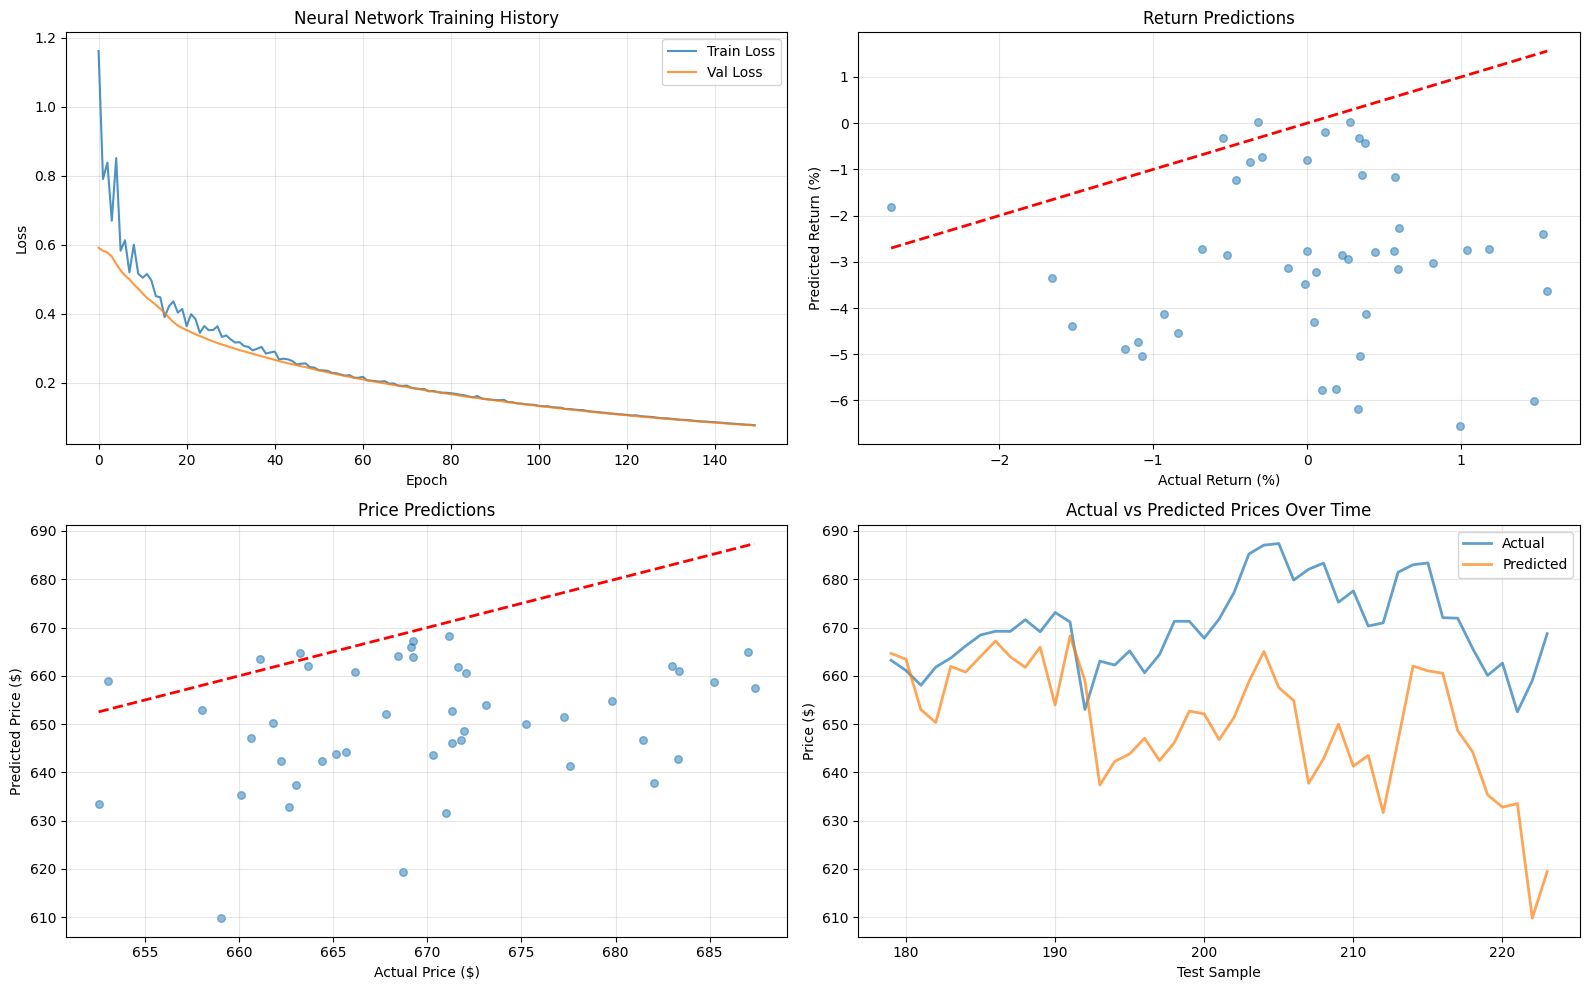

Total samples: 224
Features: ['Close', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBP_5_2.0_2.0', 'OBV', 'CMF', 'return_5d']

Target (next day return) stats:
  Mean: 0.068%
  Std: 1.284%
  Min: -5.85%, Max: 10.50%

Train: 179, Test: 45

Training Neural Network...

Training Gradient Boosting Model...

RESULTS
MAE on return prediction: 2.003%
MAE on price prediction: $13.47
MAPE: 2.00%
Directional Accuracy: 48.89%

Sample Predictions (last 10 test days):
----------------------------------------------------------------------------------------------------
Current      Act Return   Pred Return  Actual Next  Pred Next    Error       
----------------------------------------------------------------------------------------------------
$681.44            +0.23%       -0.26% $683.00      $679.68      $      -3.32
$683.00            +0.06%       -0.63% $683.38      $678.70      $      -4.68
$683.38           

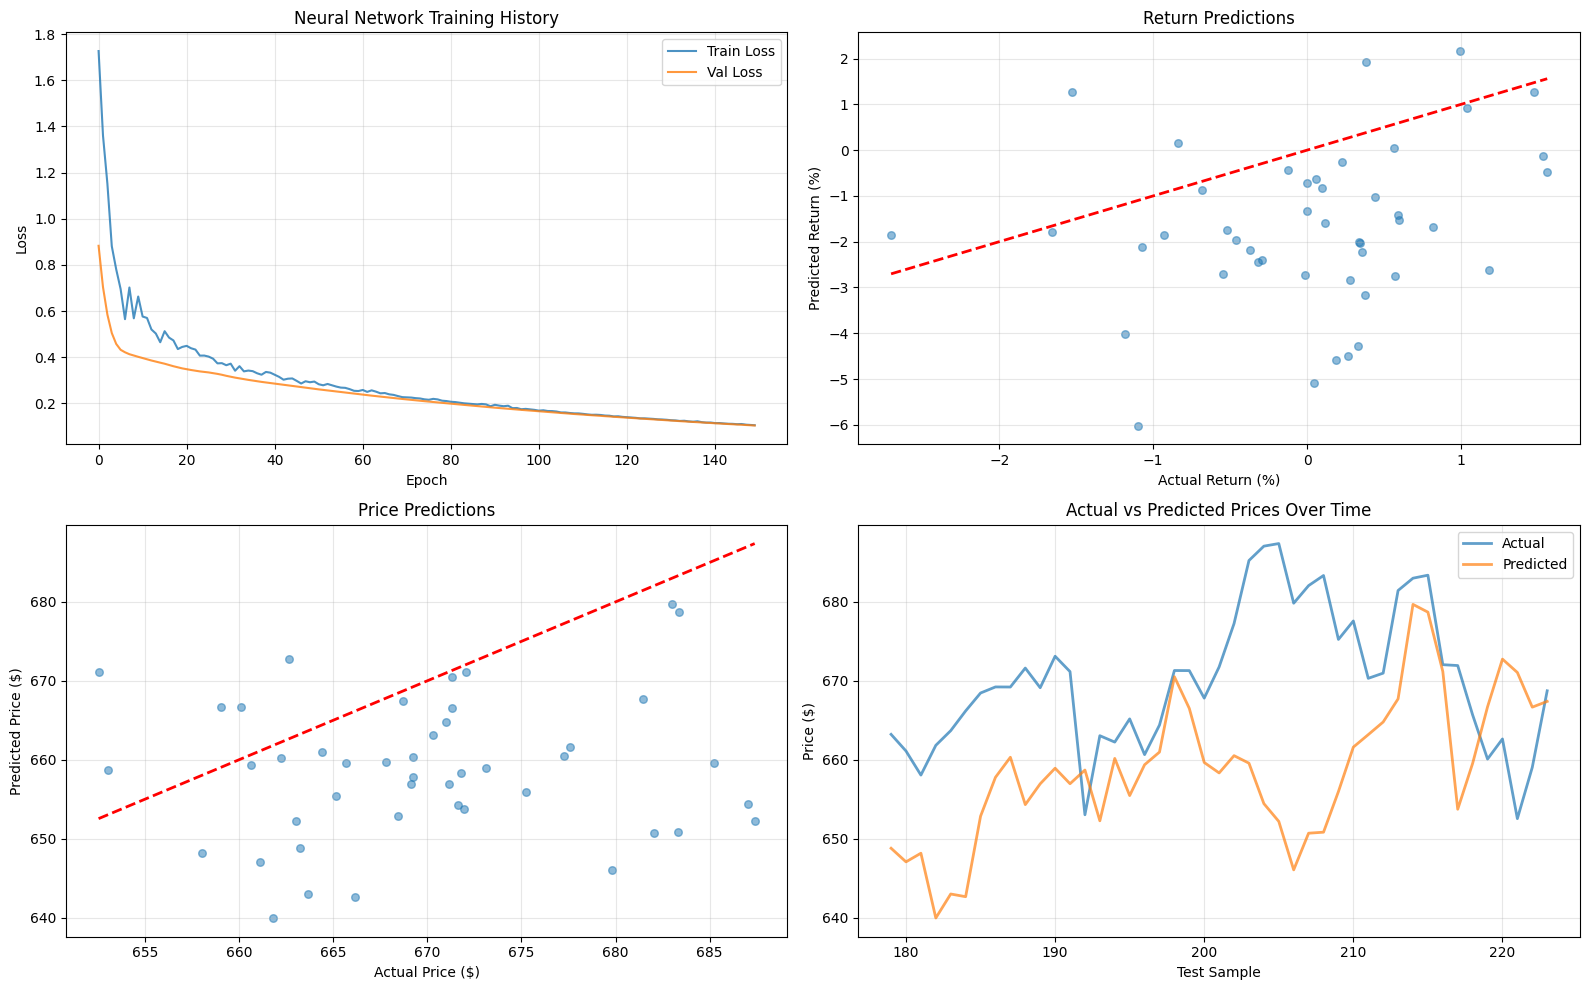



Predicted Next-Day SPY Close 2025-11-25: $674.70
Previous Day Spy Close 2025-11-24: 668.73
Predicted change: $+5.97


In [162]:
# Train models
df = pd.read_csv('spy_hist_indicator.csv')

avg_pred = []
# # Predict tomorrow
for i in range(10):
  nn_model, gb_model, scaler, feature_cols = train_model(df, epochs=150)
  tomorrow_price, tomorrow_return = predict_next_day(nn_model, gb_model, scaler, feature_cols, df)
  avg_pred.append(int(tomorrow_price))

pred_price = sum(avg_pred)/len(avg_pred)
today_close = df.iloc[-1]['Close']

#
print(f"\n{'='*60}")
print(f"\nPredicted Next-Day SPY Close {next_day_str}: ${pred_price:.2f}")
print(f"Previous Day Spy Close {df.iloc[-1]['Date']}: {today_close:.2f}")
print(f"Predicted change: ${(pred_price - today_close):+.2f}")
print(f"{'='*60}")

## **Summary**
The goal of this project was to make a machine learning model and apply concepts learned in class; such as feature engineering, tunning, and data anaylsis. The models used in this are Linear Regression, Gradient Boosting, and Neural Network.

After getting dataset (from 2025-01-01 to 2025-11-24) from PolygonIO. I performed some feature engineering, which involved using stock market indicators (such as exponential moving average EMA, volatility, etc.) which uses the High, Low, Open, Close, and Volume to derive the indicators. Indicatores are used to signal a trend in the market which can very helpful for the models.

Next I performed a basic data analysis on the dataset. First thing I did was to look for any NaN values, which resulted in none. After that I did correlation matrix heatmap. This told me some features were potentially adding noise. I removed the following features from the dataset before moving forward.
- ["Date",'Volume', 'BBB_5_2.0_2.0', 'volatility_20d', 'return_1d'].

Linear Regression was the first model we used. We split the dataset into 80% 20% (80% for training and 20% for testing). We got an RMSE of 6.76 and MAE of 4.65, which indicates that on average is off by those amount. As shown by the picture below it predicted 663.80 but the actually closing price was 675.02 for 2025-11-25. That is $12 difference, which is off from what the RMSE and MAE tells us; but that is to be expected since those are just averages.
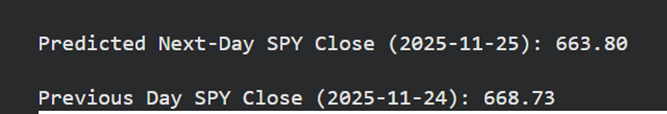

The next model is Gradient Boosting. I had high hopes for this model, since it performed better in the class activities. By looking at the screenshot below, it has an RMSE of 13.14. The prediction for this model was 658.57 versus the actual of 675.02, thats a difference of $16.5 below the actual. If we look at what gradient boosting does, it tries to find nonlinear patters, but as it turns out the stock market is very much linear. This make senses why it is way off.
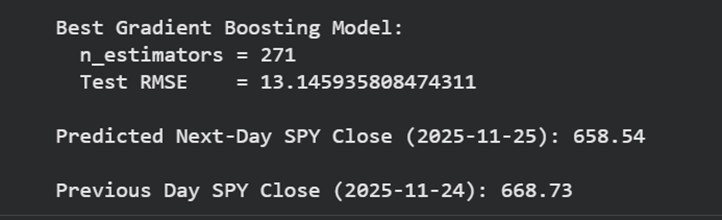

Neural network was the last model I used. I was optimistic for this model, since NN mimics human neurons, to try to find patterns. As shown by the screenshot below it predicted the closing price to be 666.40 versus 675.02 for 2025-11-25. That is a difference of $9 which is near in performance as linear regression. The caveat of this is that NN don't give a definitive price. If I were to run the model again it would be give a different result. I ran the model multiple times on average to me it seem to perform close to linear regression.
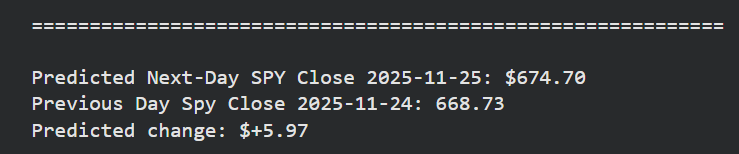

Now which model would I use? well is a hard question. I like linear regression because it gives a concrete answer and it prediction are usually off around $5-15. Additionally I also like it because, linear regression are good with linear trends, which the stock market certainly is.

On the other hand NN performed almost as good as the liner regression. The downside is that each time it runs it gives a different result. However this variability could be useful since the stock market will always be hard to predict.

For me the winner is NN. With linear regression, the result is static, when the real market is always changing. With NN, it gives a different result each time its run. The NN feels like is more flexible and more realistic to the stock market.

Overall this was a great project, we applied basic fundamental of machine learning, and pick which model I though would be best. There was some struggle in the beginning. I had issues with data not aligning correctly, it was getting offset by a day. The real struggle was building the models itself. I had to use tools like AI to help assist. After experiment a bit, I came to the conclusion that using 80% of the dataset for training and 20% for testing seemed optimal. As for the NN, using learning rate of 0.001 for the NN and 0.1 for the gradient boosting ensemble, made the model perform better.